In [1]:
# Environment Variables: 

YES = 1
NO = 0

In [2]:
# Google Drive:
using_google_drive = NO

if using_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# Imports for Training

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline
output_scaler = StandardScaler()
print(tf.config.list_physical_devices('GPU'))

2024-12-31 10:53:00.013631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 10:53:00.069575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-31 10:53:00.069591: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-31 10:53:00.501716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

[]


2024-12-31 10:53:00.943602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-31 10:53:00.946851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-31 10:53:00.946888: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-31 10:53:00.946917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-31 10:53:00.946946: W tensorflow/c

In [4]:
# Read H5 Data File:
DATA_DIR = '/mnt/Research/Data/' # Change to your DATA PATH

RHEED_DATA_FILE = DATA_DIR + 'RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

normalized_images = []
for image in raw_data:
    normalized_images.append(image / np.max(image))
normalized_images = np.array(normalized_images).astype(np.float32)

print(f'[Normalized Images Shape]: {normalized_images.shape}')

[Normalized Images Shape]: (150985, 48, 48)


[Normalized Image #106678]:


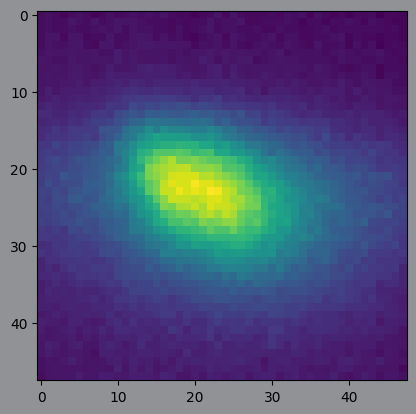

In [5]:
# Validate Data Array:
validate_data_array = YES

if validate_data_array:
    rand_int = np.random.randint(low=0, high=normalized_images.shape[0])
    print(f'[Normalized Image #{rand_int}]:')
    plt.imshow(normalized_images[rand_int])

In [6]:
# Functions for estimating labels

# generate 2d Gaussian from its parameters
# x, y = x-coord, y-coord
# A = amplitude
# x0, y0 = mean-x, mean-y
# sigma_x, sigma_y = std.-dev.-x, std.-dev.-y
def gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y):
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

# Initial guess for each parameter
# data = normalized image
def add_guess(data):
    A_guess = np.max(data)
    x0_guess, y0_guess = np.unravel_index(np.argmax(data), data.shape)
    sigma_x_guess = sigma_y_guess = np.std(data)
    return [A_guess, x0_guess, y0_guess, sigma_x_guess, sigma_y_guess]

# Compute residuals
# params = A, x0, y0, sigma_x, sigma_y
# x, y  = x-coord, y-coord
# data = normalized image
def residuals(params, x, y, data):
    A, x0, y0, sigma_x, sigma_y = params
    model = gaussian_2D(x, y, A, x0, y0, sigma_x, sigma_y)
    return (model - data).ravel()

# Convert parameters from A, x0, y0, sigma_x, sigma_y --> mean_x, mean_y, cov_x, cov_y, theta
# params = A, x0, y0, sigma_x, sigma_y
def convert_parameters(parameters):
    A, x0, y0, sigma_x, sigma_y = parameters
    mean_x = x0
    mean_y = y0
    cov_x = sigma_x
    cov_y = sigma_y

    if cov_x != 0 and cov_y != 0:
        theta = 0.5 * np.arctan(2 * cov_x * cov_y / (cov_x**2 - cov_y**2)+1e-9)
    else:
        theta = 0.0

    return mean_x, mean_y, cov_x, cov_y, theta

@delayed
def fit_gaussian_2D_delayed(data, guess):
    y, x = np.indices(data.shape)
    result = least_squares(residuals, guess, args=(x, y, data))
    return result.x


In [7]:
# Estimate Labels:
load_labels = YES # (Takes <1 min to load, ~40 mins to generate)

# Import From File

if load_labels:
    RHEED_LABEL_FILE = DATA_DIR + 'Labels.npy'
    estimated_labels = np.load(RHEED_LABEL_FILE)
    # estimated_labels = np.random.rand(normalized_images.shape[0], 5)

# Generate
else:
    estimated_labels = []
    with Client() as client:
        guesses = [add_guess(image) for image in normalized_images]
        fits = [fit_gaussian_2D_delayed(image, guess) for image, guess in zip(normalized_images, guesses)]
        estimated_labels = [convert_parameters(params) for params in compute(*fits)]
    estimated_labels = np.array(estimated_labels).astype(np.float32)

print(f'[Estimated Labels Shape]: {estimated_labels.shape}')

[Estimated Labels Shape]: (150985, 5)


In [8]:
# Create DataSet:
batch_size = 1000

with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(normalized_images)
    dataset = dataset.shuffle(normalized_images.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)

output_scaler.fit(estimated_labels)

2024-12-31 10:53:13.173162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-31 10:53:13.176198: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1391477760 exceeds 10% of free system memory.


StandardScaler()

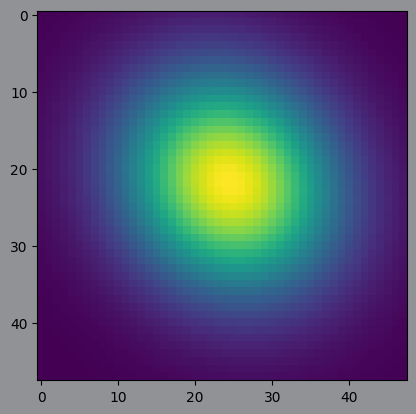

In [17]:
# Gaussian Function: (TENSORFLOW)
print_example_guassian = YES

# mean_x, mean_y, cov_x, cov_y, theta
def generate_guassian(batch, image_shape):
    batch_size = batch.shape[0]
    mean_x, mean_y, cov_x, cov_y, theta = tf.unstack(batch, axis=-1)
    x = tf.range(image_shape[1], dtype=tf.float32)[:, tf.newaxis]
    x = tf.tile(x, [1, image_shape[0]])

    y = tf.range(image_shape[0], dtype=tf.float32)[tf.newaxis, :]
    y = tf.tile(y, [image_shape[1], 1])

    x = tf.tile(tf.expand_dims(x, 0), [batch_size, 1, 1])
    y = tf.tile(tf.expand_dims(y, 0), [batch_size, 1, 1])

    rota_matrix = tf.stack([tf.cos(theta), -tf.sin(theta), tf.sin(theta), tf.cos(theta)], axis=-1)
    rota_matrix = tf.reshape(rota_matrix, (batch_size, 2, 2))

    xy = tf.stack([x - tf.reshape(mean_x, (-1, 1, 1)), y - tf.reshape(mean_y, (-1, 1, 1))], axis=-1)
    xy = tf.einsum('bijk,bkl->bijl', xy, rota_matrix)

    img = tf.exp(-0.5 * (xy[:, :, :, 0]**2 / tf.reshape(cov_x, (-1, 1, 1))**2 + xy[:, :, :, 1]**2 / tf.reshape(cov_y, (-1, 1, 1))**2))

    return tf.expand_dims(img, axis=-1) # if (batch_size, height, width, channels)
    # return tf.expand_dims(img, axis=1) # 1 if (batch_size, channels, height, width)

if print_example_guassian:
    image_shape = (48, 48)
    batch = tf.convert_to_tensor([
        [21.8558168, 24.50041009, 10.31268177, 9.1700225, 0.72681534]
        , [21.76068143, 24.37956637, 10.30043488, 9.15426013, 0.72655111]
        , [21.72363929, 24.31050759, 10.33800891, 9.18570812, 0.72644599]
        , [21.72777699, 24.29306623, 10.30178808, 9.14728058, 0.72610718]
        , [21.79849472, 24.34649405, 10.32683150, 9.16259293, 0.72573213]
    ])
    generated_imgs = generate_guassian(batch, image_shape)
    plt.imshow(tf.squeeze(generated_imgs[0]))
    plt.show()
    

In [18]:
# Custom Loss Function (TENSORFLOW):
print_example_loss = YES

def custom_weighted_mse_loss(I, J, n):
  W = tf.pow(I, n)

  squared_diffs = tf.pow(I - J, 2)

  weighted_squared_diffs = W * squared_diffs

  loss = tf.reduce_mean(weighted_squared_diffs)

  return loss

if print_example_loss:
  I = tf.random.normal((5, 1, 48, 48))
  J = tf.random.normal((5, 1, 48, 48))
  n = 2
  loss = custom_weighted_mse_loss(I, J, n)
  print("[Custom Weighted MSE Loss]:", loss.numpy())

[Custom Weighted MSE Loss]: 4.100764


In [19]:
# Model Architecture

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid'),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05),  # if (batch_size, height, width, channels)
        # tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05), # if (batch_size, channels, height, width)
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=4, strides=4),

        tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid'),
        tf.keras.layers.BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-05), # if (batch_size, height, width, channels)
        # tf.keras.layers.BatchNormalization(axis=1, momentum=0.1, epsilon=1e-05), # if (batch_size, channels, height, width)
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=98, activation='relu'),
        tf.keras.layers.Dense(units=52, activation='relu'),
        tf.keras.layers.Dense(units=5)
    ]
)

model.compile(optimizer='adam', loss=custom_weighted_mse_loss)

In [21]:
# Training Loop
train_model = YES
save_model = YES
load_model = NO

if train_model:
    best_loss = float('inf')
    num_epochs = 200
    lr = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    n = 1

    for epoch in range(num_epochs):
        running_loss = 0.0

        if epoch % 10 == 0:
            n += 0.1

        for image_batch in tqdm(dataset): 
            image_batch = tf.expand_dims(image_batch, axis=-1) # if (batch_size, height, width, channels)
            # image_batch = tf.expand_dims(image_batch, axis=1) # if (batch_size, channels, height, width)
            with tf.GradientTape() as tape:
                embedding = model(image_batch)
                unscaled_param = tf.constant(embedding * output_scaler.var_ ** 0.5 + output_scaler.mean_)
                final = generate_guassian(unscaled_param, (48,48))
                loss = custom_weighted_mse_loss(image_batch, final, n)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            running_loss += loss.numpy()
        average_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")

if save_model:
    model.save("Gaussian_Modle.keras")

if load_model:
    pass

model.summary()

100%|██████████| 151/151 [00:41<00:00,  3.67it/s]


Epoch [1/200], Loss: 0.006858943505150988


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [2/200], Loss: 0.005519265395323962


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [3/200], Loss: 0.003996418610165846


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [4/200], Loss: 0.003639327898769584


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [5/200], Loss: 0.0034475536347792443


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [6/200], Loss: 0.0034151894120585838


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [7/200], Loss: 0.0033972863807953547


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [8/200], Loss: 0.0033856554539713835


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [9/200], Loss: 0.003376603735586172


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [10/200], Loss: 0.0033702420083102803


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [11/200], Loss: 0.003034176812229666


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [12/200], Loss: 0.0030299416320731507


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [13/200], Loss: 0.003026001420587499


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [14/200], Loss: 0.0030222109824246325


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [15/200], Loss: 0.003018931792555562


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [16/200], Loss: 0.0030162129258206544


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [17/200], Loss: 0.003013527753226311


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [18/200], Loss: 0.0030116670586119425


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [19/200], Loss: 0.0030098171173810763


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [20/200], Loss: 0.0030087896218733085


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [21/200], Loss: 0.0027130581623572387


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [22/200], Loss: 0.0027119189081405174


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [23/200], Loss: 0.00271098002088287


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [24/200], Loss: 0.0027100943161532383


100%|██████████| 151/151 [00:41<00:00,  3.67it/s]


Epoch [25/200], Loss: 0.002709274821674192


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [26/200], Loss: 0.0027085225150260506


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [27/200], Loss: 0.002707916840799893


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [28/200], Loss: 0.002707178519409619


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [29/200], Loss: 0.002706420006514188


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [30/200], Loss: 0.0027060289728449076


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [31/200], Loss: 0.0024435959944489184


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [32/200], Loss: 0.0024426466035995854


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [33/200], Loss: 0.002442323820147392


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [34/200], Loss: 0.002441878772852634


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [35/200], Loss: 0.0024417490090878793


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [36/200], Loss: 0.002441099880337222


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [37/200], Loss: 0.0024406928553659195


100%|██████████| 151/151 [00:41<00:00,  3.67it/s]


Epoch [38/200], Loss: 0.002440319046538496


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [39/200], Loss: 0.0024398476477490356


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [40/200], Loss: 0.0024396480748812292


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [41/200], Loss: 0.0022058076632289303


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [42/200], Loss: 0.0022051556310338886


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [43/200], Loss: 0.002205044347237771


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [44/200], Loss: 0.002204558224608468


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [45/200], Loss: 0.002204408593142763


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [46/200], Loss: 0.0022040996700525284


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [47/200], Loss: 0.002203975110283948


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [48/200], Loss: 0.0022035408209984666


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [49/200], Loss: 0.0022033852330772884


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [50/200], Loss: 0.002203216558840397


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [51/200], Loss: 0.0019942924938479204


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [52/200], Loss: 0.001994200717713314


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [53/200], Loss: 0.001993784991660408


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [54/200], Loss: 0.0019936077759311293


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [55/200], Loss: 0.0019935461313198535


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [56/200], Loss: 0.0019933129128821146


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [57/200], Loss: 0.001993052242015371


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [58/200], Loss: 0.0019931161979719106


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [59/200], Loss: 0.0019928579903300235


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [60/200], Loss: 0.001992784811350338


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [61/200], Loss: 0.0018059501227065428


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [62/200], Loss: 0.001805705562640993


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [63/200], Loss: 0.0018055604929597864


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [64/200], Loss: 0.0018055961738704452


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [65/200], Loss: 0.0018053509469224227


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [66/200], Loss: 0.0018053261535427231


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [67/200], Loss: 0.0018052684593427655


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [68/200], Loss: 0.0018053023755204994


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [69/200], Loss: 0.0018051161040669146


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [70/200], Loss: 0.0018050983950606738


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [71/200], Loss: 0.0016376048493020187


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [72/200], Loss: 0.001637506031196885


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [73/200], Loss: 0.0016375144346870037


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [74/200], Loss: 0.0016374112367444973


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [75/200], Loss: 0.0016373585622807014


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [76/200], Loss: 0.001637288136407733


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [77/200], Loss: 0.0016374339292516674


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [78/200], Loss: 0.0016371329208613923


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [79/200], Loss: 0.0016373046989928907


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [80/200], Loss: 0.0016370111666249715


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [81/200], Loss: 0.0014870744923265366


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [82/200], Loss: 0.0014869261044231767


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [83/200], Loss: 0.0014867844809438812


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [84/200], Loss: 0.0014868434225609958


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [85/200], Loss: 0.0014867778892153935


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [86/200], Loss: 0.0014867739233848274


100%|██████████| 151/151 [00:40<00:00,  3.68it/s]


Epoch [87/200], Loss: 0.0014867551990211108


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [88/200], Loss: 0.0014867601547673937


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [89/200], Loss: 0.0014866035854110852


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [90/200], Loss: 0.0014865192930084586


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [91/200], Loss: 0.0013521043429558246


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [92/200], Loss: 0.001351832418350984


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [93/200], Loss: 0.001351790582076554


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [94/200], Loss: 0.0013518170600090892


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [95/200], Loss: 0.0013518633377978837


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [96/200], Loss: 0.0013517063852732643


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [97/200], Loss: 0.0013517136685550213


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [98/200], Loss: 0.001351706906443844


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [99/200], Loss: 0.0013515617928177809


100%|██████████| 151/151 [00:41<00:00,  3.68it/s]


Epoch [100/200], Loss: 0.001351675377165689


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [101/200], Loss: 0.0012307761418972386


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [102/200], Loss: 0.0012304547153388625


100%|██████████| 151/151 [00:40<00:00,  3.69it/s]


Epoch [103/200], Loss: 0.0012304818963891032


100%|██████████| 151/151 [00:40<00:00,  3.70it/s]


Epoch [104/200], Loss: 0.0012304996948269819


100%|██████████| 151/151 [00:40<00:00,  3.70it/s]


Epoch [105/200], Loss: 0.0012305591206084813


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [106/200], Loss: 0.0012304737951162438


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [107/200], Loss: 0.0012304419235307847


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [108/200], Loss: 0.0012303474004571604


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [109/200], Loss: 0.0012304262514071947


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [110/200], Loss: 0.0012303582795075332


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [111/200], Loss: 0.0011215335388809738


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [112/200], Loss: 0.0011215177380066636


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [113/200], Loss: 0.0011214964517349045


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [114/200], Loss: 0.0011214633851577313


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [115/200], Loss: 0.0011215128686081692


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [116/200], Loss: 0.0011213704494956807


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [117/200], Loss: 0.0011214409678841368


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [118/200], Loss: 0.0011213237299454331


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [119/200], Loss: 0.0011213979427856916


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [120/200], Loss: 0.0011213635239404756


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [121/200], Loss: 0.0010236212081701451


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [122/200], Loss: 0.0010233052816575035


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [123/200], Loss: 0.0010233180426270855


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [124/200], Loss: 0.0010233072267956291


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [125/200], Loss: 0.0010232195999806389


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [126/200], Loss: 0.0010233291706983124


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [127/200], Loss: 0.0010232505340758242


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [128/200], Loss: 0.001023275849397066


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [129/200], Loss: 0.0010233001694058544


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [130/200], Loss: 0.0010233680973606592


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [131/200], Loss: 0.0009350576835055373


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [132/200], Loss: 0.0009348740348660245


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [133/200], Loss: 0.000934878968639879


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [134/200], Loss: 0.0009349301940798513


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [135/200], Loss: 0.0009348819433982848


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [136/200], Loss: 0.0009348683170234131


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [137/200], Loss: 0.0009349870036004592


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [138/200], Loss: 0.0009348453986242611


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [139/200], Loss: 0.0009348448581796213


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [140/200], Loss: 0.0009348029108866063


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [141/200], Loss: 0.0008552978620926128


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [142/200], Loss: 0.0008551523171130888


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [143/200], Loss: 0.0008551987691393849


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [144/200], Loss: 0.0008552155383424649


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [145/200], Loss: 0.0008551594851359676


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [146/200], Loss: 0.0008551885592843721


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [147/200], Loss: 0.0008551237868786549


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [148/200], Loss: 0.0008551549295191683


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [149/200], Loss: 0.0008551472896673032


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [150/200], Loss: 0.0008552053146101288


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [151/200], Loss: 0.0007832349194768841


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [152/200], Loss: 0.0007831649962713979


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [153/200], Loss: 0.0007832406219002476


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [154/200], Loss: 0.0007831710664438244


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [155/200], Loss: 0.0007831514959488779


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [156/200], Loss: 0.0007831628907730939


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [157/200], Loss: 0.0007831911145499753


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [158/200], Loss: 0.0007831522372292219


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [159/200], Loss: 0.0007832022090843379


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [160/200], Loss: 0.0007831010954386697


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [161/200], Loss: 0.0007182459350033904


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [162/200], Loss: 0.0007181532152108108


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [163/200], Loss: 0.0007181413697590743


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [164/200], Loss: 0.0007181217869287295


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [165/200], Loss: 0.0007180996479725601


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [166/200], Loss: 0.0007181961331454828


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [167/200], Loss: 0.0007181060423346742


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [168/200], Loss: 0.0007180725393927847


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [169/200], Loss: 0.0007181624378484754


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [170/200], Loss: 0.0007182098416278497


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [171/200], Loss: 0.0006593337459088802


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [172/200], Loss: 0.0006592947760726394


100%|██████████| 151/151 [00:40<00:00,  3.71it/s]


Epoch [173/200], Loss: 0.0006593553047158466


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [174/200], Loss: 0.0006592674778361145


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [175/200], Loss: 0.0006592873135421253


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [176/200], Loss: 0.000659290076285872


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [177/200], Loss: 0.0006592808706093802


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [178/200], Loss: 0.0006593550441305567


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [179/200], Loss: 0.0006592124735239573


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [180/200], Loss: 0.0006592167276944595


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [181/200], Loss: 0.0006060833720465666


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [182/200], Loss: 0.0006060928841806109


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [183/200], Loss: 0.0006060748891473212


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [184/200], Loss: 0.0006060471668814784


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [185/200], Loss: 0.000606015973742928


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [186/200], Loss: 0.0006060893832403698


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [187/200], Loss: 0.0006060117118628017


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [188/200], Loss: 0.0006060389395562672


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [189/200], Loss: 0.0006059936813652417


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [190/200], Loss: 0.0006059638050304639


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [191/200], Loss: 0.000557866280155244


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [192/200], Loss: 0.0005577386700739431


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [193/200], Loss: 0.0005577573932812161


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [194/200], Loss: 0.000557758488818781


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [195/200], Loss: 0.0005577788507066272


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [196/200], Loss: 0.0005577433370948084


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [197/200], Loss: 0.0005577577533206551


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]


Epoch [198/200], Loss: 0.000557707616094105


100%|██████████| 151/151 [00:40<00:00,  3.73it/s]


Epoch [199/200], Loss: 0.0005577760255149264


100%|██████████| 151/151 [00:40<00:00,  3.72it/s]

Epoch [200/200], Loss: 0.0005577327941840404
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 44, 44, 6)         156       
                                                                 
 batch_normalization_2 (Batc  (None, 44, 44, 6)        24        
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 44, 44, 6)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 16)          2416      
                                                                 
 batch_no

In [22]:
# Imports for Quantizing

import qkeras
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump

In [24]:
# Post Training Quantization
save_qmodel = YES

q_dict = {
    "QConv2D": {
        "kernel_quantizer": "quantized_bits(4,0,1)",
        "bias_quantizer": "quantized_bits(4,0,1)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_bits(4,0,1)",
        "bias_quantizer": "quantized_bits(4,0,1)"
    },
    "QBatchNormalization": {},

    "QActivation": "quantized_relu(4,0)"
}

qmodel = model_quantize(model, q_dict, 4, transfer_weights=True)
print_qstats(qmodel)

if save_qmodel:
    qmodel.save("Quantized_Gaussian_Modle.keras")



Number of operations in model:
    conv2d_2                      : 290400 (smult_4_8)
    conv2d_3                      : 117600 (smult_4_4)
    dense_3                       : 14112 (smult_4_4)
    dense_4                       : 5096  (smult_4_4)
    dense_5                       : 260   (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 137068
    smult_4_8                     : 290400

Weight profiling:
    conv2d_2_weights               : 150   (4-bit unit)
    conv2d_2_bias                  : 6     (4-bit unit)
    conv2d_3_weights               : 2400  (4-bit unit)
    conv2d_3_bias                  : 16    (4-bit unit)
    dense_3_weights                : 14112 (4-bit unit)
    dense_3_bias                   : 98    (4-bit unit)
    dense_4_weights                : 5096  (4-bit unit)
    dense_4_bias                   : 52    (4-bit unit)
    dense_5_weights                : 260   (4-bit unit)
    dense_5_bias                   : 5     (4-bit 